In [ ]:
!pip install yfinance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import precision_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

#Data Source
import yfinance as yf

import re
import tensorflow as tf
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import Embedding,Dense,LSTM,Dropout,Flatten,BatchNormalization,Conv1D,GlobalMaxPooling1D,MaxPooling1D, Attention
tf.random.set_seed(7)


In [ ]:
class DataFrameCollection:
    def __init__(self):

        from google.colab import drive
        drive.mount('/content/drive')


        self.list_of_tickers = ['OKE','VALE','MSFT','NVDA',
                                'AMD','LTHM','ALB','SNPS',
                                'IRM','T','PAYC','TSLA','KDP',
                                'COIN','SNOW','AMZN','CRM','GOOGL',
                                'LMT','^GSPC']

        self.dataframes = []
        self.end_date = datetime.now().strftime('%Y-%m-%d')
        self.news_data = self.retrieve_news_data()
        self.train_index = []
        self.test_index = []

    def retrieve_financial_data(self):
        for i in self.list_of_tickers:
            data = yf.Ticker(i)
            hist = data.history(start='2000-01-01',end=self.end_date)
            dataframe = pd.DataFrame(hist)

            dataframe['date'] = dataframe.index
            pattern = r'\d\d\d\d-\d\d-\d\d'
            re_matches = []

            for value in dataframe['date']:
                value = str(value)
                match = re.search(pattern, value)
                if match:
                    re_matches.append(match.group())
                else:
                    re_matches.append('no match')

            dataframe['dt'] = re_matches
            dataframe['dt'] = pd.to_datetime(dataframe['dt'], format='%Y-%m-%d')
            dataframe.set_index('dt', inplace=True)


            window_size = 5
            window_size2 = 10
            window_size3 = 20

            numbers_series = dataframe['Close']
            windows = numbers_series.rolling(window_size)
            moving_averages = windows.mean()
            moving_averages_list = moving_averages.tolist()
            dataframe['Five_day_rolling'] = moving_averages_list

            numbers_series = dataframe['Close']
            windows = numbers_series.rolling(window_size2)
            moving_averages = windows.mean()
            moving_averages_list = moving_averages.tolist()
            dataframe['Ten_day_rolling'] = moving_averages_list

            numbers_series = dataframe['Close']
            windows = numbers_series.rolling(window_size3)
            moving_averages = windows.mean()
            moving_averages_list = moving_averages.tolist()
            dataframe['Twenty_day_rolling'] = moving_averages_list

            # Assuming 'datetime_column' is your datetime variable in the DataFrame
            #dataframe['date_column'] = dataframe['datetime_column'].dt.date

            dataframe['stock'] = i
            dataframe['Target'] = dataframe['Close'].shift(-20)
            dataframe.dropna(inplace=True)

            self.dataframes .append(dataframe)




    def retrieve_news_data(self):
        df = pd.read_csv('/content/drive/My Drive/news/grouped_with_sentiment.csv')
        df['date'] = pd.to_datetime(df['clean_dates'], format='%Y/%m/%d')
        df.set_index('date', inplace=True)
        return df

    def return_news_data(self):
        return self.news_data

    def return_dataframes(self):
        return self.dataframes


    def display_news_df(self):
        print(self.news_data.head())

    def display_specific_df(self, idx):
        print(f"DataFrame {idx + 1}:")
        print('Shape of Dataframe: ', self.dataframes[idx].shape)
        print(self.dataframes[idx].head())
        #print(self.dataframes[idx].tail())
        print()



collection = DataFrameCollection()
collection.retrieve_financial_data()
financial_data = collection.return_dataframes()
news_data = collection.return_news_data()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


clean_dates
headline
snippet
head_pos
head_neg
head_neu
snippet_pos
snippet_neg
snippet_neu


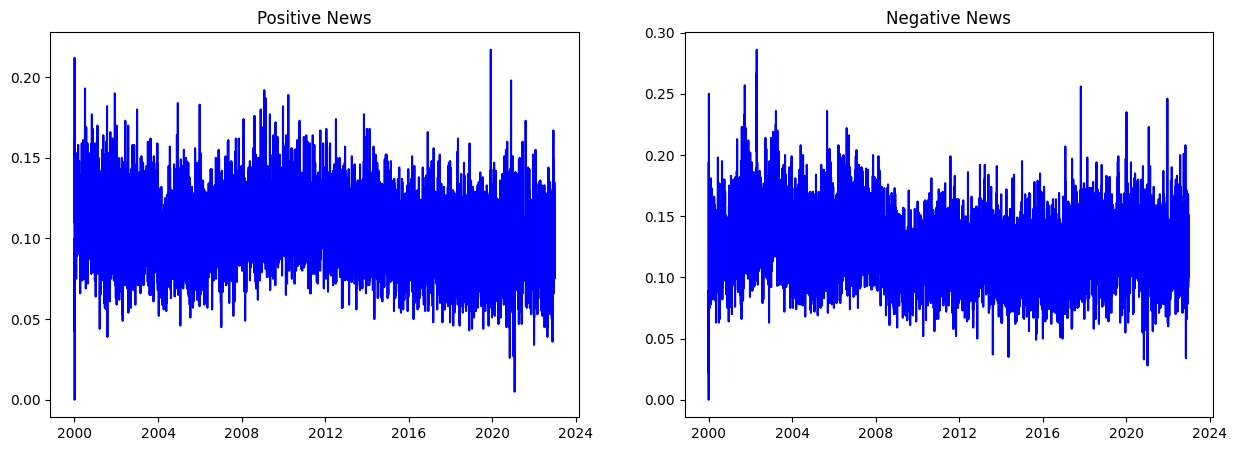

In [ ]:


class Explore_News_Data:
      def __init__(self, param1):
        self.news_df = param1
        self.index = pd.to_datetime(self.news_df['clean_dates'], format='%Y/%m/%d')
        #self.index = self.news_df['clean_dates']


      def view_data(self):
        print(self.financial_df[0].head())
        print(self.news_df.head())

      def hist_of_news_data(self):
        # Looking at the title sentiments
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle('Histograms of News Data Titles')
        axs[0].hist(self.news_df['head_pos'])
        axs[0].set_title('Title Positive')
        axs[1].hist(self.news_df['head_neg'])
        axs[1].set_title('Title Negative')
        axs[2].hist(self.news_df['head_neu'])
        axs[2].set_title('Title Neutral')
        plt.show()
        #  looking at the snippet sentiments
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle('Histograms of News Data Snippets')
        axs[0].hist(self.news_df['snippet_pos'])
        axs[0].set_title('Snippet Positive')
        axs[1].hist(self.news_df['snippet_neg'])
        axs[1].set_title('Snippet Negative')
        axs[2].hist(self.news_df['snippet_neu'])
        axs[2].set_title('Snippet Neutral')
        plt.show()

      def line_of_news_data(self):
        for i in self.news_df.columns:
          print(i)
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))
        # Create a line graph
        axs[0].plot(self.index, self.news_df['head_pos'], color='b', label='Data')
        axs[0].set_title('Positive News')
        # Create a line graph
        axs[1].plot(self.index, self.news_df['head_neg'], color='b', label='Data')
        axs[1].set_title('Negative News')

        # Display the graph
        plt.show()



data_exploration = Explore_News_Data(news_data)
data_exploration.line_of_news_data()



20


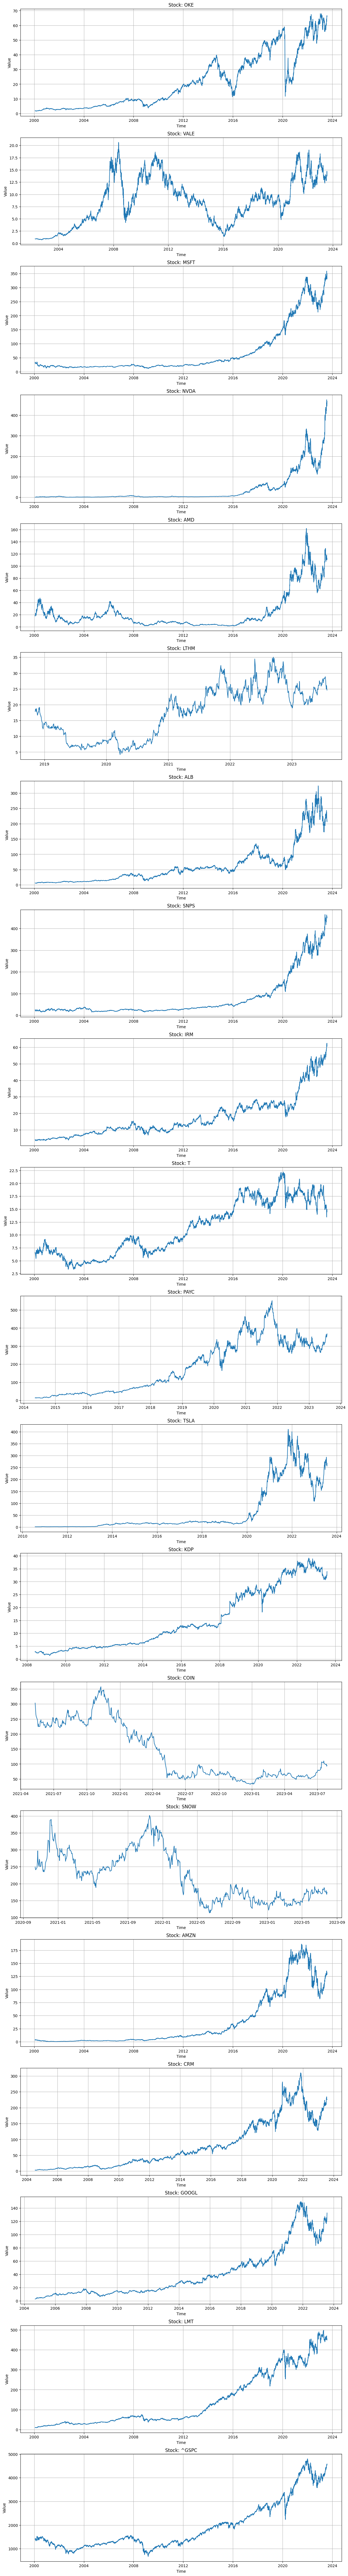

In [ ]:
class Explore_Financial_Data:
      def __init__(self, param1):
        self.financial_df = param1

        self.list_of_tickers = ['OKE','VALE','MSFT','NVDA',
                                'AMD','LTHM','ALB','SNPS',
                                'IRM','T','PAYC','TSLA','KDP',
                                'COIN','SNOW','AMZN','CRM','GOOGL',
                                'LMT','^GSPC']


        print(len(self.financial_df))



      def plot_financial_data(self):
        fig, axs = plt.subplots(len(self.financial_df), 1, figsize=(15, 120))
        for idx, df in enumerate(self.financial_df):
            axs[idx].set_title('Stock: ' + str(self.list_of_tickers[idx]))
            axs[idx].set_xlabel('Time')
            axs[idx].set_ylabel('Value')
            axs[idx].grid(True)  # Add grid lines
            axs[idx].plot(self.financial_df[idx]['Close'])
            #plt.show()




finance_exploration = Explore_Financial_Data(financial_data)
finance_exploration.plot_financial_data()




In [ ]:

class Join_Data:
      def __init__(self, financial_data, news_data):
        self.financial_df = financial_data
        self.news_df = news_data
        self.market_df = pd.DataFrame()

        self.combined_dfs = []
        self.dfs_with_timesteps = []


      def view_financial_df(self, indx):
        print(self.financial_df[indx].index)
        print(self.financial_df[indx])

      def view_news_df(self):
        print(self.news_df.index)
        print(self.news_df)


      def pop_market_df(self):
        # Remove the last item which is the sp500
        market_copy = self.financial_df.pop()
        df = pd.DataFrame()
        df['market_open'] = market_copy['Open']
        df['market_high'] = market_copy['High']
        df['market_low'] = market_copy['Low']
        df['market_close'] = market_copy['Close']
        df['market_volume'] = market_copy['Volume']
        df['market_five_roll'] = market_copy['Five_day_rolling']
        df['market_ten_roll'] = market_copy['Ten_day_rolling']
        df['market_twenty_roll'] = market_copy['Twenty_day_rolling']
        self.market_df = df


      def column_names(self, i):
        new_column_names = {'Open': 'Open' + str(i),
                            'High': 'High' + str(i),
                            'Low': 'Low' + str(i),
                            'Close': 'Close' + str(i),
                            'Volume': 'Volume' + str(i),
                            'Five_day_rolling': 'Five_day_rolling' + str(i),
                            'Ten_day_rolling': 'Ten_day_rolling' + str(i),
                            'Twenty_day_rolling': 'Twenty_day_rolling' + str(i),
                            'head_pos': 'head_pos' + str(i),
                            'head_neg': 'head_neg' + str(i),
                            'market_open': 'market_open' + str(i),
                            'market_high': 'market_high' + str(i),
                            'market_low': 'market_low' + str(i),
                            'market_close': 'market_close' + str(i),
                            'market_volume': 'market_volume' + str(i),
                            'market_five_roll': 'market_five_roll' + str(i),
                            'market_ten_roll': 'market_ten_roll' + str(i),
                            'market_twenty_roll': 'market_twenty_roll' + str(i)}
        return new_column_names


      def make_time_steps(self, df):
        # Shift the variables down by 1 row
        shifted_df_1 = df.shift(1)
        shifted_df_2 = df.shift(2)
        shifted_df_3 = df.shift(3)
        shifted_df_4 = df.shift(4)
        shifted_df_5 = df.shift(5)

        X = ['Open', 'High', 'Low', 'Close','Volume','Five_day_rolling','Ten_day_rolling','Twenty_day_rolling',
             'head_pos','head_neg',
             'market_open', 'market_high', 'market_low', 'market_close', 'market_volume', 'market_five_roll', 'market_ten_roll', 'market_twenty_roll']

        X_with_target = ['Target','Open', 'High', 'Low', 'Close','Volume','Five_day_rolling','Ten_day_rolling','Twenty_day_rolling',
             'head_pos','head_neg',
             'market_open', 'market_high', 'market_low', 'market_close', 'market_volume', 'market_five_roll', 'market_ten_roll', 'market_twenty_roll']

        df = df[X_with_target]

        shifted_df_1 = shifted_df_1[X]
        new_column_names_1 = self.column_names(1)
        shifted_df_1.rename(columns=new_column_names_1, inplace=True)

        shifted_df_2 = shifted_df_2[X]
        new_column_names_2 = self.column_names(2)
        shifted_df_2.rename(columns=new_column_names_2, inplace=True)

        shifted_df_3 = shifted_df_3[X]
        new_column_names_3 = self.column_names(3)
        shifted_df_3.rename(columns=new_column_names_3, inplace=True)

        shifted_df_4 = shifted_df_4[X]
        new_column_names_4 = self.column_names(4)
        shifted_df_4.rename(columns=new_column_names_4, inplace=True)

        shifted_df_5 = shifted_df_5[X]
        new_column_names_5 = self.column_names(5)
        shifted_df_5.rename(columns=new_column_names_5, inplace=True)

        # Append the shifted variables to the original DataFrame
        result_df = pd.concat([df, shifted_df_1, shifted_df_2, shifted_df_3, shifted_df_4, shifted_df_5], axis=1)
        return result_df


      def combine_dataframes(self):
        # Join based on index
        for df in self.financial_df:
          joined_df = df.join(self.news_df)
          joined_df_two = joined_df.join(self.market_df)
          self.combined_dfs.append(joined_df_two)
        #return self.combined_dfs


      def loop_time_step_creation(self):
        for df in self.combined_dfs:
          ts_df = self.make_time_steps(df)
          self.dfs_with_timesteps.append(ts_df)
        return self.dfs_with_timesteps





data_joiner = Join_Data(financial_data, news_data)
data_joiner.pop_market_df()
data_joiner.combine_dataframes()
dfs_ready = data_joiner.loop_time_step_creation()

<ipython-input-27-137382b11a7a>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shifted_df_3.rename(columns=new_column_names_3, inplace=True)


In [ ]:
for i in dfs_ready[0].columns:
  print(i)

print(dfs_ready[0].shape)

Target
Open
High
Low
Close
Volume
Five_day_rolling
Ten_day_rolling
Twenty_day_rolling
head_pos
head_neg
market_open
market_high
market_low
market_close
market_volume
market_five_roll
market_ten_roll
market_twenty_roll
Open1
High1
Low1
Close1
Volume1
Five_day_rolling1
Ten_day_rolling1
Twenty_day_rolling1
head_pos1
head_neg1
market_open1
market_high1
market_low1
market_close1
market_volume1
market_five_roll1
market_ten_roll1
market_twenty_roll1
Open2
High2
Low2
Close2
Volume2
Five_day_rolling2
Ten_day_rolling2
Twenty_day_rolling2
head_pos2
head_neg2
market_open2
market_high2
market_low2
market_close2
market_volume2
market_five_roll2
market_ten_roll2
market_twenty_roll2
Open3
High3
Low3
Close3
Volume3
Five_day_rolling3
Ten_day_rolling3
Twenty_day_rolling3
head_pos3
head_neg3
market_open3
market_high3
market_low3
market_close3
market_volume3
market_five_roll3
market_ten_roll3
market_twenty_roll3
Open4
High4
Low4
Close4
Volume4
Five_day_rolling4
Ten_day_rolling4
Twenty_day_rolling4
head_pos

In [ ]:
from sklearn.preprocessing import StandardScaler


copy = dfs_ready[0].copy()
print('Before', copy.shape)
copy.dropna(inplace=True)
print('After',copy.shape)


train = copy.iloc[:-90]
test = copy.iloc[-90:]
print('Train: ', train.shape)
print('Test: ', test.shape)


X_train = train.iloc[:, 1:].values
Y_train = train['Target'].values
X_test = test.iloc[:, 1:].values
Y_test = test['Target'].values

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)


# Convert to numpy arrays
x_train_nn = np.array(X_train)
y_train_nn = np.array(Y_train)
x_test_nn = np.array(X_test)
y_test_nn = np.array(Y_test)

# Assuming you have split your data into X_train and X_test
scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Transform both training and test data using the same scaler
X_train_scaled = scaler.transform(x_train_nn)
X_test_scaled = scaler.transform(x_test_nn)



print(X_train_scaled.shape)
print(X_test_scaled.shape)


# Example data: n samples, each with m features
m = 18
timesteps = 6



# Reshape the data to match neural network input shape
x_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], timesteps, m)  # Adding an extra dimension for single feature
x_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], timesteps, m)  # Adding an extra dimension for single feature



##################################################################################
##################################################################################

# Define input shape and number of time steps and features
input_shape = (6, 18)

# Create a Sequential model
model = Sequential()

# Add an LSTM layer
lstm_units = 200  # Number of LSTM units
model.add(LSTM(units=lstm_units, input_shape=input_shape))

# Add a Dense output layer
dense_units = 1  # Number of units in the output layer
model.add(Dense(units=dense_units))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary
hist = model.fit(x_train_reshaped, y_train_nn, epochs=10, batch_size=4, verbose=1)






Before (5911, 109)
After (5757, 109)
Train:  (5667, 109)
Test:  (90, 109)
(5667, 108)
(5667,)
(90, 108)
(90,)
(5667, 108)
(90, 108)
Epoch 1/10
1417/1417 [==============================] - 6s 3ms/step - loss: 35.0135
Epoch 2/10
1417/1417 [==============================] - 5s 3ms/step - loss: 9.7791
Epoch 3/10
1417/1417 [==============================] - 5s 3ms/step - loss: 9.0065
Epoch 4/10
1417/1417 [==============================] - 5s 3ms/step - loss: 8.6501
Epoch 5/10
1417/1417 [==============================] - 5s 3ms/step - loss: 7.8891
Epoch 6/10
1417/1417 [==============================] - 5s 3ms/step - loss: 7.2063
Epoch 7/10
1417/1417 [==============================] - 5s 3ms/step - loss: 7.6603
Epoch 8/10
1417/1417 [==============================] - 5s 3ms/step - loss: 7.3364
Epoch 9/10
1417/1417 [==============================] - 5s 3ms/step - loss: 6.8081
Epoch 10/10
1417/1417 [==============================] - 5s 3ms/step - loss: 6.5808


In [ ]:

predictions = model.predict(x_test_reshaped)


mse = mean_squared_error(y_test_nn, predictions)
print("MSE: ", mse)




plt.plot(predictions, label='Predictions')
plt.plot(y_test_nn, label='Actual')
plt.legend()
plt.show()



NameError: ignored

In [ ]:
class Model_Builder:
    def __init__(self, df):
        self.df = df
        self.y_train_nn = None
        self.y_test_nn = None
        self.x_train_reshaped = None
        self.x_test_reshaped = None

        self.best_model = None
        self.best_mse = None


    def train_test_scale(self):
        copy = dfs_ready[0].copy()
        copy.dropna(inplace=True)

        train = copy.iloc[:-90]
        test = copy.iloc[-90:]

        X_train = train.iloc[:, 1:].values
        Y_train = train['Target'].values
        X_test = test.iloc[:, 1:].values
        Y_test = test['Target'].values

        # Convert to numpy arrays
        x_train_nn = np.array(X_train)
        y_train_nn = np.array(Y_train)
        x_test_nn = np.array(X_test)
        y_test_nn = np.array(Y_test)
        self.y_train_nn = y_train_nn
        self.y_test_nn = y_test_nn

        # Assuming you have split your data into X_train and X_test
        scaler = StandardScaler()

        # Fit the scaler on the training data
        scaler.fit(X_train)

        # Transform both training and test data using the same scaler
        X_train_scaled = scaler.transform(x_train_nn)
        X_test_scaled = scaler.transform(x_test_nn)

        # Example data: n samples, each with m features
        m = 18
        timesteps = 6

        # Reshape the data to match neural network input shape
        self.x_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], timesteps, m)  # Adding an extra dimension for single feature
        self.x_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], timesteps, m)  # Adding an extra dimension for single feature


    def build_and_optimize_models(self):
        epochs = [10, 20, 30]
        batch_sizes = [4, 16, 32, 64]
        lstm_units = [200, 500, 1000]
        input_shape = (6, 18)

        model = Sequential()
        model.add(LSTM(units=100, input_shape=input_shape))
        dense_units = 1  # Number of units in the output layer
        model.add(Dense(units=dense_units))
        model.compile(optimizer='adam', loss='mean_squared_error')
        hist = model.fit(self.x_train_reshaped, self.y_train_nn, epochs=5, batch_size=4, verbose=1)
        predictions = model.predict(self.x_test_reshaped)
        mse = mean_squared_error(self.y_test_nn, predictions)

        print("MSE: ", mse)

        self.best_model = model
        self.best_mse = mse

        for epoch in epochs:
            for batch_size in batch_sizes:
                for lstm_unit in lstm_units:
                    # Create a Sequential model
                    model = Sequential()
                    model.add(LSTM(units=lstm_unit, input_shape=input_shape))
                    dense_units = 1  # Number of units in the output layer
                    model.add(Dense(units=dense_units))
                    model.compile(optimizer='adam', loss='mean_squared_error')
                    hist = model.fit(self.x_train_reshaped, self.y_train_nn, epochs=epoch, batch_size=batch_size, verbose=1)
                    predictions = model.predict(self.x_test_reshaped)
                    mse = mean_squared_error(self.y_test_nn, predictions)

                    print("MSE: ", mse)

                    if mse < self.best_mse:
                        self.best_model = model
                        self.best_mse = mse


    def return_best_model(self):
        return self.best_model

    def return_best_mse(self):
        return self.best_mse










builder = Model_Builder(dfs_ready[0])
builder.train_test_scale()
builder.build_and_optimize_models()


Epoch 1/5
1417/1417 [==============================] - 6s 3ms/step - loss: 65.3543
Epoch 2/5
1417/1417 [==============================] - 5s 3ms/step - loss: 10.1560
Epoch 3/5
1417/1417 [==============================] - 5s 3ms/step - loss: 8.8899
Epoch 4/5
1417/1417 [==============================] - 5s 3ms/step - loss: 8.4003
Epoch 5/5
3/3 [==============================] - 0s 3ms/step
MSE:  65.63432197779103
Epoch 1/10
1417/1417 [==============================] - 7s 3ms/step - loss: 33.6493
Epoch 2/10
1417/1417 [==============================] - 5s 3ms/step - loss: 9.5925
Epoch 3/10
1417/1417 [==============================] - 5s 3ms/step - loss: 8.9339
Epoch 4/10
1417/1417 [==============================] - 5s 3ms/step - loss: 8.5805
Epoch 5/10
1417/1417 [==============================] - 5s 3ms/step - loss: 7.8740
Epoch 6/10
1417/1417 [==============================] - 5s 3ms/step - loss: 7.4954
Epoch 7/10
1417/1417 [==============================] - 5s 3ms/step - loss: 7.5738
Epo

In [ ]:
model = builder.return_best_model()
mse = builder.return_best_mse()


In [ ]:
print(mse)

31.784294230389545


In [ ]:
preds = model.predict(builder.x_test_reshaped)


3/3 [==============================] - 0s 3ms/step


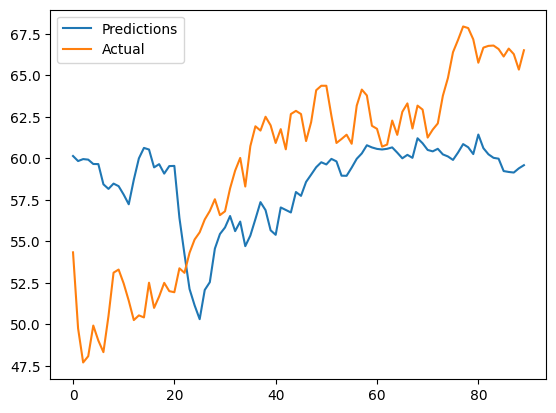

In [ ]:
plt.plot(preds, label='Predictions')
plt.plot(y_test_nn, label='Actual')
plt.legend()
plt.show()
